## This is based on MakeMyPostISRCCDfromRawForSpectractorSD 

In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates

import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib.colors import LogNorm

from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.ticker                         # here's where the formatter is
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from astropy.visualization import (MinMaxInterval, SqrtStretch,ZScaleInterval,PercentileInterval,
                                   ImageNormalize,imshow_norm)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch


from astropy.io import fits




In [2]:
# Assembly task
# https://github.com/lsst/ip_isr/blob/main/python/lsst/ip/isr/isrTask.py

from lsst.ip.isr.assembleCcdTask import (AssembleCcdConfig, AssembleCcdTask)
from lsst.ip.isr.isrTask import (IsrTask, IsrTaskConfig)

#https://github.com/lsst/ip_isr/blob/main/python/lsst/ip/isr/overscan.py
from lsst.ip.isr import  OverscanCorrectionTaskConfig, OverscanCorrectionTask

In [3]:
# LSST Display
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('matplotlib')

In [4]:
import warnings
warnings.filterwarnings("ignore")

# Butler 

In [5]:
import lsst.daf.butler as dafButler

In [6]:
embargo = True

In [7]:
if embargo:
    repo="/sdf/group/rubin/repo/oga/"
else:
    repo = "/sdf/group/rubin/repo/main"
butler = dafButler.Butler(repo)
registry = butler.registry

Select collection containing raw data 

In [8]:
#collection='LATISS/raw/all'
cameraName = 'LATISS'
calibCollections = ['LATISS/defaults','LATISS/raw/all']
for col in registry.queryCollections("*LATISS/calib*"):
    #print(col)
    calibCollections.append(col)

## Dataframe with the science exposures 

Set up dataframe to store the list of exposures and their information. Select only SCIENCE exposures 

In [9]:
df_science = pd.DataFrame(columns=['id', 'obs_id','day_obs', 'seq_num','time_start',
                                    'time_end' ,'type', 'target','filter_disp','zenith_angle',
                                    'expos','ra','dec','skyangle','science_program'])

In [10]:

#where_exps = "instrument='LATISS' AND exposure.observation_type='science' AND exposure.day_obs={0} AND physical_filter='{1}'".format(exp_date,physical_filter)
where_exps = "instrument='LATISS' AND exposure.observation_type='flat'"
for i, info in enumerate(registry.queryDimensionRecords('exposure',where=where_exps)):
    
    #if info.observation_type=='science':
    id_ = info.id
    obs_id_ = info.obs_id
    day_obs_ = info.day_obs
    seq_num_ = info.seq_num
    timespan_ = info.timespan
    timespan_begin_ = pd.to_datetime(timespan_.begin.to_string())
    timespan_end_ = pd.to_datetime(timespan_.end.to_string())
    timespan_begin_jd_ = timespan_.begin.jd
    timespan_begin_mjd_ = timespan_.begin.mjd

    observation_type_ = info.observation_type
    target_name_ = info.target_name
    physical_filter_ = info.physical_filter
    zenith_angle_ = info.zenith_angle
    exposure_time_ = info.exposure_time
    tracking_ra_ = info.tracking_ra
    tracking_dec_ = info.tracking_dec
    sky_angle_ = info.sky_angle
    science_program_ = info.science_program

    df_science.loc[i] = [id_, obs_id_, day_obs_, seq_num_,timespan_begin_,timespan_end_ ,observation_type_, \
                         target_name_, physical_filter_, zenith_angle_, exposure_time_,tracking_ra_, \
                         tracking_dec_, sky_angle_, science_program_]

    if i < 2:
        print(i)
        print(info)
        print("\t timespan:            ",info.timespan)
        print("\t timespan.begin:      ",info.timespan.begin)
        print("\t id:                  ",info.id)
        print("\t day_obs:             ",info.day_obs)
        print("\t seq_num:             ",info.seq_num)
        print("\t type-of-observation: ",info.observation_type)
        print("\t target:              ",info.target_name)
        print("-----------------------------------------------------")
    

0
exposure:
  instrument: 'LATISS'
  id: 2022090200006
  physical_filter: 'unknown~unknown'
  obs_id: 'AT_O_20220902_000006'
  exposure_time: 2.0
  dark_time: 2.23911
  observation_type: 'flat'
  observation_reason: 'flat'
  day_obs: 20220902
  seq_num: 6
  seq_start: 6
  seq_end: 6
  group_name: '2022090200006'
  group_id: 2022090200006
  target_name: 'UNKNOWN'
  science_program: 'unknown'
  tracking_ra: None
  tracking_dec: None
  sky_angle: None
  azimuth: None
  zenith_angle: None
  has_simulated: False
  timespan: Timespan(begin=astropy.time.Time('2022-09-02 19:41:26.805005', scale='tai', format='iso'), end=astropy.time.Time('2022-09-02 19:41:29.045000', scale='tai', format='iso'))
	 timespan:             [2022-09-02T19:41:26.805005, 2022-09-02T19:41:29.045000)
	 timespan.begin:       2022-09-02 19:41:26.805005
	 id:                   2022090200006
	 day_obs:              20220902
	 seq_num:              6
	 type-of-observation:  flat
	 target:               UNKNOWN
--------------

In [11]:
df_science.tail(5)

,id,obs_id,day_obs,seq_num,time_start,time_end,type,target,filter_disp,zenith_angle,expos,ra,dec,skyangle,science_program
5707,2023083000143,AT_O_20230830_000143,20230830,143,2023-08-30 22:07:31.709989,2023-08-30 22:07:37.947,flat,FlatField position,SDSSi_65mm~empty,51.057706,6.0,229.882642,-81.106739,None,unknown
5708,2023083000146,AT_O_20230830_000146,20230830,146,2023-08-30 22:07:57.891983,2023-08-30 22:08:04.129,flat,FlatField position,SDSSi_65mm~empty,51.057719,6.0,229.990206,-81.106940,None,unknown
5709,2023083000149,AT_O_20230830_000149,20230830,149,2023-08-30 22:08:24.085001,2023-08-30 22:08:30.328,flat,FlatField position,SDSSi_65mm~empty,51.057731,6.0,230.097777,-81.107139,None,unknown
5710,2023083000152,AT_O_20230830_000152,20230830,152,2023-08-30 22:08:50.275002,2023-08-30 22:08:56.506,flat,FlatField position,SDSSi_65mm~empty,51.057746,6.0,230.205363,-81.107341,None,unknown
5711,2023083000155,AT_O_20230830_000155,20230830,155,2023-08-30 22:09:16.475987,2023-08-30 22:09:22.716,flat,FlatField position,SDSSi_65mm~empty,51.057755,6.0,230.317097,-81.107545,None,unknown


In [12]:
len(df_science)

5712

Available sources 

In [13]:
np.unique(np.array(df_science.target.array).astype('str'))

array(['FlatField position', 'Park position', 'UNKNOWN', 'azel_target',
       'slew_icrs'], dtype='<U18')

Available dates 

In [14]:
np.unique(np.array(df_science.day_obs.array))

array([20220902, 20220907, 20220908, 20220912, 20220913, 20220914,
       20220922, 20220923, 20220927, 20220928, 20220929, 20221004,
       20221005, 20221007, 20221011, 20221012, 20221013, 20221025,
       20221026, 20221027, 20221103, 20221104, 20221108, 20221109,
       20221110, 20221122, 20221123, 20221124, 20221209, 20221211,
       20221212, 20230110, 20230112, 20230116, 20230117, 20230118,
       20230119, 20230127, 20230131, 20230201, 20230202, 20230207,
       20230209, 20230214, 20230215, 20230216, 20230301, 20230311,
       20230314, 20230321, 20230327, 20230404, 20230420, 20230425,
       20230427, 20230502, 20230505, 20230509, 20230510, 20230511,
       20230522, 20230523, 20230524, 20230525, 20230704, 20230705,
       20230706, 20230718, 20230719, 20230720, 20230724, 20230725,
       20230726, 20230727, 20230801, 20230802, 20230803, 20230811,
       20230816, 20230817, 20230822, 20230823, 20230829, 20230830])

Available filters 

In [15]:
np.unique(np.array(df_science.filter_disp.array))

array(['BG40_65mm_1~empty', 'FELH0600~empty', 'OG550_65mm_1~empty',
       'OG550_65mm_1~holo4_003', 'SDSSg_65mm~empty', 'SDSSi_65mm~empty',
       'SDSSi_65mm~holo4_003', 'SDSSr_65mm~empty', 'SDSSr~empty',
       'empty~blue300lpmm_qn1', 'empty~empty', 'empty~holo4_003',
       'empty~ronchi170lpmm', 'unknown~unknown'], dtype=object)

In [16]:
# set 'all' to select all values 
exp_date = 'all'
physical_filter = 'empty~empty'
source = 'all'

In [17]:
#df_science[df_science.target==source]
#df_science[(df_science.target==source) & (df_science.day_obs==exp_date)]

In [18]:
if exp_date!='all':
    df_science = df_science[df_science.day_obs==exp_date]
if source!='all':
    df_science = df_science[df_science.target==source]
if physical_filter!='all':
    df_science = df_science[df_science.filter_disp==physical_filter]

In [19]:
df_science.tail(5)

,id,obs_id,day_obs,seq_num,time_start,time_end,type,target,filter_disp,zenith_angle,expos,ra,dec,skyangle,science_program
5686,2023083000080,AT_O_20230830_000080,20230830,80,2023-08-30 21:48:29.675990,2023-08-30 21:48:30.920,flat,FlatField position,empty~empty,51.056891,1.0,225.159613,-81.098019,None,unknown
5687,2023083000083,AT_O_20230830_000083,20230830,83,2023-08-30 21:48:40.871986,2023-08-30 21:48:42.112,flat,FlatField position,empty~empty,51.056901,1.0,225.205082,-81.098102,None,unknown
5688,2023083000086,AT_O_20230830_000086,20230830,86,2023-08-30 21:48:52.074018,2023-08-30 21:48:53.334,flat,FlatField position,empty~empty,51.056914,1.0,225.250600,-81.098189,None,unknown
5689,2023083000089,AT_O_20230830_000089,20230830,89,2023-08-30 21:49:03.286993,2023-08-30 21:49:04.519,flat,FlatField position,empty~empty,51.056925,1.0,225.296040,-81.098272,None,unknown
5690,2023083000092,AT_O_20230830_000092,20230830,92,2023-08-30 21:49:14.475988,2023-08-30 21:49:15.716,flat,FlatField position,empty~empty,51.056934,1.0,225.345660,-81.098363,None,unknown


In [20]:
len(df_science)

666

In [21]:
if exp_date!='all':
    assert df_science.day_obs.unique()[0]==exp_date

In [22]:
if source!='all':
    assert df_science.target.unique()[0]==source

In [23]:
if physical_filter!='all':
    assert df_science.filter_disp.unique()[0]==physical_filter

In [24]:
exposures_selected = []
for index,row in df_science.iterrows():
    #exposure_selected_ = row["day_obs"]*100000+row["seq_num"]
    exposure_selected_ = row["id"]
    #print(exposure_selected_)
    exposures_selected.append(exposure_selected_)
print(exposures_selected)

[2022091200073, 2022091400100, 2022091400104, 2022091400105, 2022091400103, 2022091400108, 2022091400109, 2022091400114, 2022091400112, 2022091400101, 2022091400111, 2022091400106, 2022091400107, 2022091400102, 2022091400113, 2022091400115, 2022091400110, 2022092200029, 2022092200028, 2022092200030, 2022092200027, 2022092200072, 2022092200074, 2022092200081, 2022092200083, 2022092200076, 2022092200080, 2022092200084, 2022092200090, 2022092200031, 2022092200077, 2022092200075, 2022092200079, 2022092200073, 2022092200078, 2022092200082, 2022092200087, 2022092200089, 2022092200088, 2022092200086, 2022092200093, 2022092200094, 2022092200096, 2022092200100, 2022092200101, 2022092200102, 2022092200092, 2022092200091, 2022092200095, 2022092200097, 2022092200099, 2022092200103, 2022092200098, 2022092300263, 2022092700190, 2022092700191, 2022092700193, 2022092700194, 2022092700192, 2022092700195, 2022092700196, 2022092700199, 2022092700197, 2022092700198, 2022100400083, 2022101100805, 202212090

In [25]:
#exp_test = exposures_selected[0]
exp_test = 2023021500279

In [26]:
raw_img= butler.get('raw', dataId={'exposure': exp_test, 'instrument': 'LATISS', 'detector': 0}, collections = calibCollections)

In [27]:
flat_img= butler.get('flat', dataId={'exposure': exp_test, 'instrument': 'LATISS', 'detector': 0}, collections = calibCollections)

LookupError: Dataset flat with data ID {instrument: 'LATISS', detector: 0, exposure: 2023021500279, ...} could not be found in collections ['LATISS/defaults', 'LATISS/raw/all', 'LATISS/calib/DM-28636/curated/19700101T000000Z', 'LATISS/calib/DM-28636/curated/20180101T000000Z', 'LATISS/calib/DM-28636/unbounded', 'LATISS/calib/DM-28636', 'LATISS/calib/DM-33875', 'LATISS/calib', 'LATISS/calib/unbounded', 'LATISS/calib/DM-36484/biasGen.20221005a', 'LATISS/calib/DM-36484/biasGen.20221005a/20221006T000101Z', 'LATISS/calib/DM-36484/verifyBias.20221005a', 'LATISS/calib/DM-36484/verifyBias.20221005a/20221006T000747Z', 'LATISS/calib/DM-36484/verifyBias.20221005a/20221006T213237Z', 'LATISS/calib/DM-36484/darkGen.20221005a', 'LATISS/calib/DM-36484/darkGen.20221005a/20221006T222501Z', 'LATISS/calib/DM-36484/darkGen.20221006a', 'LATISS/calib/DM-36484/darkGen.20221006a/20221006T222921Z', 'LATISS/calib/DM-36484/verifyDark.20221006a', 'LATISS/calib/DM-36484/verifyDark.20221006a/20221006T224403Z', 'LATISS/calib/DM-36484/flatGen-SDSSr.20221006a', 'LATISS/calib/DM-36484/flatGen-SDSSr.20221006a/20221006T233657Z', 'LATISS/calib/DM-36484/verifyFlat-SDSSr.20221006a', 'LATISS/calib/DM-36484/verifyFlat-SDSSr.20221006a/20221006T234341Z', 'LATISS/calib/DM-36484/flatGen-SDSSg.20221006a', 'LATISS/calib/DM-36484/flatGen-SDSSg.20221006a/20221007T002703Z', 'LATISS/calib/DM-36484/verifyFlat-SDSSg.20221006a', 'LATISS/calib/DM-36484/verifyFlat-SDSSg.20221006a/20221007T003418Z', 'LATISS/calib/DM-36484/flatGen-SDSSi.20221006a', 'LATISS/calib/DM-36484/flatGen-SDSSi.20221006a/20221007T003732Z', 'LATISS/calib/DM-36484/verifyFlat-SDSSi.20221006a', 'LATISS/calib/DM-36484/verifyFlat-SDSSi.20221006a/20221007T004423Z', 'LATISS/calib/DM-36484/flatGen-SDSSiD.20221006a', 'LATISS/calib/DM-36484/flatGen-SDSSiD.20221006a/20221007T004708Z', 'LATISS/calib/DM-36484/bias.20221005a', 'LATISS/calib/DM-36484/dark.20221006a', 'LATISS/calib/DM-36484/flat-SDSSg.20221006a', 'LATISS/calib/DM-36484/flat-SDSSr.20221006a', 'LATISS/calib/DM-36484/flat-SDSSi.20221006a', 'LATISS/calib/DM-36484/verifyBias.20221005b', 'LATISS/calib/DM-36484/verifyBias.20221005b/20221019T205236Z', 'LATISS/calib/DM-38563/noRGseq/darkGen.20230718.1', 'LATISS/calib/DM-38563/noRGseq/darkGen.20230718.1/20230717T222513Z', 'LATISS/calib/DM-38563/noRGseq/verifyDark.20230718.1', 'LATISS/calib/DM-38563/noRGseq/verifyDark.20230718.1/20230717T222752Z', 'LATISS/calib/DM-38563/noRGseq/verifyBias.20230719.1', 'LATISS/calib/DM-38563/noRGseq/verifyBias.20230719.1/20230719T221427Z', 'LATISS/calib/DM-39635', 'LATISS/calib/DM-39635/unbounded', 'LATISS/calib/DM-39635/curated/19700101T000000Z', 'LATISS/calib/DM-39635/curated/20180101T000000Z', 'LATISS/calib/DM-38563/noRGseq/flatGen-i.20230718.1', 'LATISS/calib/DM-38563/noRGseq/flatGen-i.20230718.1/20230717T223306Z', 'LATISS/calib/DM-39635/curated/20221005T000000Z', 'LATISS/calib/DM-38563/noRGseq/verifyFlat-i.20230718.1', 'LATISS/calib/DM-38563/noRGseq/verifyFlat-i.20230718.1/20230717T223725Z', 'LATISS/calib/DM-38563/noRGseq/flatGen-i.20230719.1', 'LATISS/calib/DM-38563/noRGseq/flatGen-i.20230719.1/20230719T222106Z', 'LATISS/calib/DM-36719/biasGen.20221107a', 'LATISS/calib/DM-36719/biasGen.20221107a/20221107T205127Z', 'LATISS/calib/DM-36719/biasGen.20221107b', 'LATISS/calib/DM-36719/biasGen.20221107b/20221107T213306Z', 'LATISS/calib/DM-36719/verifyBias.20221107b', 'LATISS/calib/DM-36719/verifyBias.20221107b/20221107T220410Z', 'LATISS/calib/DM-36719/darkGen.20221107a', 'LATISS/calib/DM-36719/darkGen.20221107a/20221107T223409Z', 'LATISS/calib/DM-36719/verifyDark.20221107a', 'LATISS/calib/DM-36719/verifyDark.20221107a/20221107T232823Z', 'LATISS/calib/DM-36719/flatGen-SDSSr.20221107a', 'LATISS/calib/DM-36719/flatGen-SDSSr.20221107a/20221107T235401Z', 'LATISS/calib/DM-36719/verifyFlat-SDSSr.20221107a', 'LATISS/calib/DM-36719/verifyFlat-SDSSr.20221107a/20221108T000940Z', 'LATISS/calib/DM-36719/flatGen-SDSSg.20221107a', 'LATISS/calib/DM-36719/flatGen-SDSSg.20221107a/20221108T002737Z', 'LATISS/calib/DM-36719/verifyFlat-SDSSg.20221107a', 'LATISS/calib/DM-36719/verifyFlat-SDSSg.20221107a/20221108T004225Z', 'LATISS/calib/DM-36719/flatGen-SDSSi.20221107a', 'LATISS/calib/DM-36719/flatGen-SDSSi.20221107a/20221108T005202Z', 'LATISS/calib/DM-36719/verifyFlat-SDSSi.20221107a', 'LATISS/calib/DM-36719/verifyFlat-SDSSi.20221107a/20221108T012110Z', 'LATISS/calib/DM-36719/verifyFlat-SDSSi.20221107a/20221108T014950Z', 'LATISS/calib/DM-36719/ptcGen-SDSSr.20221107a', 'LATISS/calib/DM-36719/ptcGen-SDSSr.20221107a/20221108T180421Z', 'LATISS/calib/DM-36719/bias.20221107', 'LATISS/calib/DM-36719/dark.20221107', 'LATISS/calib/DM-36719/flat-SDSSi.20221107', 'LATISS/calib/DM-36719/flat-SDSSr.20221107', 'LATISS/calib/DM-36719/flat-SDSSg.20221107', 'LATISS/calib/DM-36719', 'LATISS/calib/DM-37587/flatGen-BG40.20230113a', 'LATISS/calib/DM-37587/flatGen-BG40.20230113a/20230113T211456Z', 'LATISS/calib/DM-37587/verifyFlat-BG40.20230113a', 'LATISS/calib/DM-37587/verifyFlat-BG40.20230113a/20230113T212641Z', 'LATISS/calib/DM-37587/flatGen-OG550.20230113b', 'LATISS/calib/DM-37587/flatGen-OG550.20230113b/20230113T213305Z', 'LATISS/calib/DM-37587/verifyFlat-OG550.20230113b', 'LATISS/calib/DM-37587/verifyFlat-OG550.20230113b/20230113T213804Z', 'LATISS/calib/DM-37587/flatGen-SDSSr.20230113c', 'LATISS/calib/DM-37587/flatGen-SDSSr.20230113c/20230113T214159Z', 'LATISS/calib/DM-37587/verifyFlat-SDSSr.20230113c', 'LATISS/calib/DM-37587/verifyFlat-SDSSr.20230113c/20230113T220628Z', 'LATISS/calib/DM-37587/flat-BG40.20230113a', 'LATISS/calib/DM-37587/flat-OG550.20230113a', 'LATISS/calib/DM-37587/flat-SDSSr.20230113a', 'LATISS/calib/DM-38946/noRGseq/biasGen.20230428a', 'LATISS/calib/DM-38946/noRGseq/biasGen.20230428a/20230428T210637Z', 'LATISS/calib/DM-40267/flat_stability_test/flat-g.20230814', 'LATISS/calib/DM-40267/flat_stability_test/flat-empty.20230814', 'LATISS/calib/DM-39749/twilight_flats.20230814/flat-i.20230814', 'LATISS/calib/DM-38946/noRGseq/verifyBias.20230428a', 'LATISS/calib/DM-38946/noRGseq/verifyBias.20230428a/20230428T212239Z', 'LATISS/calib/DM-38946/noRGseq/darkGen.20230428a', 'LATISS/calib/DM-38946/noRGseq/darkGen.20230428a/20230428T213424Z', 'LATISS/calib/DM-38946/noRGseq/verifyBias.20230501a', 'LATISS/calib/DM-38946/noRGseq/verifyBias.20230501a/20230501T200433Z', 'LATISS/calib/DM-38946/noRGseq/verifyDark.20230501a', 'LATISS/calib/DM-38946/noRGseq/verifyDark.20230501a/20230501T201119Z', 'LATISS/calib/DM-38946/noRGseq/verifyDark.20230501a/20230501T201842Z', 'LATISS/calib/DM-38946/noRGseq/flatGen-g.20230501a', 'LATISS/calib/DM-38946/noRGseq/flatGen-g.20230501a/20230501T203920Z', 'LATISS/calib/DM-38946/noRGseq/verifyDark.20230428a', 'LATISS/calib/DM-38946/noRGseq/verifyDark.20230428a/20230428T214216Z', 'LATISS/calib/DM-38946/noRGseq/verifyDark.20230501a/20230501T202742Z', 'LATISS/calib/DM-38946/noRGseq/verifyFlat-g.20230501a', 'LATISS/calib/DM-38946/noRGseq/verifyFlat-g.20230501a/20230501T205150Z', 'LATISS/calib/DM-38946/noRGseq/flatGen-g.20230428a', 'LATISS/calib/DM-38946/noRGseq/flatGen-g.20230428a/20230428T215022Z', 'LATISS/calib/DM-38946/noRGseq/flatGen-r.20230501a', 'LATISS/calib/DM-38946/noRGseq/flatGen-r.20230501a/20230501T205909Z', 'LATISS/calib/DM-40267/flat_stability_test/flat-r.20230814', 'LATISS/calib/DM-40267/flat_stability_test', 'LATISS/calib/DM-39749/twilight_flats.20230814/flat-g.20230814', 'LATISS/calib/DM-39749/twilight_flats.20230814/flat-empty.20230814', 'LATISS/calib/DM-38946/noRGseq/verifyFlat-g.20230428a', 'LATISS/calib/DM-38946/noRGseq/verifyFlat-g.20230428a/20230428T215453Z', 'LATISS/calib/DM-38946/noRGseq/verifyFlat-r.20230501a', 'LATISS/calib/DM-38946/noRGseq/verifyFlat-r.20230501a/20230501T210446Z', 'LATISS/calib/DM-38946/noRGseq/bias.20230503', 'LATISS/calib/DM-38946/noRGseq/flat-r.20230503', 'LATISS/calib/DM-40267/flat_stability_test/flat-i.20230814', 'LATISS/calib/DM-39749/twilight_flats.20230814/flat-r.20230814', 'LATISS/calib/DM-39749/twilight_flats.20230814', 'LATISS/calib/DM-38946/noRGseq/flatGen-r.20230428a', 'LATISS/calib/DM-38946/noRGseq/flatGen-r.20230428a/20230428T215855Z', 'LATISS/calib/DM-38946/noRGseq/flatGen-i.20230501a', 'LATISS/calib/DM-38946/noRGseq/flatGen-i.20230501a/20230501T211541Z', 'LATISS/calib/DM-38946/noRGseq/dark.20230503', 'LATISS/calib/DM-38946/noRGseq/flat-i.20230503', 'LATISS/calib/DM-38946/noRGseq/verifyFlat-r.20230428a', 'LATISS/calib/DM-38946/noRGseq/verifyFlat-r.20230428a/20230428T220322Z', 'LATISS/calib/DM-38946/noRGseq/verifyFlat-i.20230501a', 'LATISS/calib/DM-38946/noRGseq/verifyFlat-i.20230501a/20230501T212007Z', 'LATISS/calib/DM-38946/noRGseq/flat-g.20230503', 'LATISS/calib/DM-38946', 'LATISS/calib/DM-38946/noRGseq/flatGen-i.20230428a', 'LATISS/calib/DM-38946/noRGseq/flatGen-i.20230428a/20230428T220722Z', 'LATISS/calib/DM-40267//flatGen-g.20230801a', 'LATISS/calib/DM-40267//flatGen-g.20230801a/20230801T221948Z', 'LATISS/calib/DM-38946/noRGseq/verifyFlat-i.20230428a', 'LATISS/calib/DM-38946/noRGseq/verifyFlat-i.20230428a/20230428T221137Z', 'LATISS/calib/DM-40267//verifyFlat-g.20230801a', 'LATISS/calib/DM-40267//verifyFlat-g.20230801a/20230801T224741Z', 'LATISS/calib/DM-40267//flatGen-r.20230801a', 'LATISS/calib/DM-40267//flatGen-r.20230801a/20230801T230705Z', 'LATISS/calib/DM-40267//verifyFlat-r.20230801a', 'LATISS/calib/DM-40267//verifyFlat-r.20230801a/20230801T233313Z', 'LATISS/calib/DM-40267//flatGen-i.20230801a', 'LATISS/calib/DM-40267//flatGen-i.20230801a/20230802T012446Z', 'LATISS/calib/DM-40267//verifyFlat-i.20230801a', 'LATISS/calib/DM-40267//verifyFlat-i.20230801a/20230802T015009Z', 'LATISS/calib/DM-40267//flatGen-x.20230801a', 'LATISS/calib/DM-40267//flatGen-x.20230801a/20230802T044912Z', 'LATISS/calib/DM-40267//verifyFlat-x.20230801a', 'LATISS/calib/DM-40267//verifyFlat-x.20230801a/20230802T073350Z', 'LATISS/calib/DM-38563/noRGseq/biasGen.20230713.1', 'LATISS/calib/DM-38563/noRGseq/biasGen.20230713.1/20230713T181502Z', 'LATISS/calib/DM-38563/noRGseq/biasGen.20230718.2', 'LATISS/calib/DM-38563/noRGseq/biasGen.20230718.2/20230718T205400Z', 'LATISS/calib/DM-38563/noRGseq/biasGen.20230720.1', 'LATISS/calib/DM-38563/noRGseq/biasGen.20230720.1/20230720T202023Z', 'LATISS/calib/DM-38563/noRGseq/verifyBias.20230720.1', 'LATISS/calib/DM-38563/noRGseq/verifyBias.20230720.1/20230720T202754Z', 'LATISS/calib/DM-38563/noRGseq/darkGen.20230713.1', 'LATISS/calib/DM-38563/noRGseq/darkGen.20230713.1/20230713T182518Z', 'LATISS/calib/DM-38563/noRGseq/verifyBias.20230718.2', 'LATISS/calib/DM-38563/noRGseq/verifyBias.20230718.2/20230718T210318Z', 'LATISS/calib/DM-38563/noRGseq/darkGen.20230720.1', 'LATISS/calib/DM-38563/noRGseq/darkGen.20230720.1/20230720T203430Z', 'LATISS/calib/DM-39749/SDSSg/flatGen-g.20230621a', 'LATISS/calib/DM-39749/SDSSg/flatGen-g.20230621a/20230621T225902Z', 'LATISS/calib/DM-38563/noRGseq/flatGen-i.20230713.1', 'LATISS/calib/DM-38563/noRGseq/flatGen-i.20230713.1/20230713T182756Z', 'LATISS/calib/DM-38563/noRGseq/biasGen.20230717.1', 'LATISS/calib/DM-38563/noRGseq/biasGen.20230717.1/20230717T184634Z', 'LATISS/calib/DM-38563/noRGseq/verifyDark.20230720.1', 'LATISS/calib/DM-38563/noRGseq/verifyDark.20230720.1/20230720T204114Z', 'LATISS/calib/DM-39749/SDSSg/verifyFlat-g.20230621a', 'LATISS/calib/DM-39749/SDSSg/verifyFlat-g.20230621a/20230621T230225Z', 'LATISS/calib/DM-39749/SDSSr/flatGen-r.20230621a', 'LATISS/calib/DM-39749/SDSSr/flatGen-r.20230621a/20230621T230446Z', 'LATISS/calib/DM-38563/noRGseq/verifyBias.20230717.1', 'LATISS/calib/DM-38563/noRGseq/verifyBias.20230717.1/20230717T185547Z', 'LATISS/calib/DM-38563/noRGseq/flatGen-i.20230718.2', 'LATISS/calib/DM-38563/noRGseq/flatGen-i.20230718.2/20230718T211014Z', 'LATISS/calib/DM-38563/noRGseq/flatGen-i.20230720.1', 'LATISS/calib/DM-38563/noRGseq/flatGen-i.20230720.1/20230720T204637Z', 'LATISS/calib/DM-39505/crosstalk.20230602', 'LATISS/calib/DM-39749/SDSSr/verifyFlat-r.20230621a', 'LATISS/calib/DM-39749/SDSSr/verifyFlat-r.20230621a/20230621T230720Z', 'LATISS/calib/DM-38563/noRGseq/darkGen.20230717.1', 'LATISS/calib/DM-38563/noRGseq/darkGen.20230717.1/20230717T190228Z', 'LATISS/calib/DM-40082', 'LATISS/calib/DM-40082/unbounded', 'LATISS/calib/DM-40082/curated/19700101T000000Z', 'LATISS/calib/DM-40082/curated/20221005T000000Z', 'LATISS/calib/DM-40082/curated/20180101T000000Z', 'LATISS/calib/DM-38563/noRGseq/verifyFlat-i.20230720.1', 'LATISS/calib/DM-38563/noRGseq/verifyFlat-i.20230720.1/20230720T205221Z', 'LATISS/calib/DM-39505', 'LATISS/calib/DM-39749/SDSSi/flatGen-i.20230621a', 'LATISS/calib/DM-39749/SDSSi/flatGen-i.20230621a/20230621T230938Z', 'LATISS/calib/DM-38563/noRGseq/verifyDark.20230717.1', 'LATISS/calib/DM-38563/noRGseq/verifyDark.20230717.1/20230717T190530Z', 'LATISS/calib/DM-39749/SDSSi/verifyFlat-i.20230621a', 'LATISS/calib/DM-39749/SDSSi/verifyFlat-i.20230621a/20230621T231200Z', 'LATISS/calib/DM-38563/noRGseq/flatGen-i.20230717.1', 'LATISS/calib/DM-38563/noRGseq/flatGen-i.20230717.1/20230717T191032Z', 'LATISS/calib/DM-39749/empty/flatGen-x.20230621a', 'LATISS/calib/DM-39749/empty/flatGen-x.20230621a/20230621T231502Z', 'LATISS/calib/DM-39749/empty/verifyFlat-x.20230621a', 'LATISS/calib/DM-39749/empty/verifyFlat-x.20230621a/20230621T231721Z', 'LATISS/calib/DM-38563/noRGseq/verifyFlat-i.20230717.1', 'LATISS/calib/DM-38563/noRGseq/verifyFlat-i.20230717.1/20230717T191458Z', 'LATISS/calib/DM-39749/SDSSg/flatGen-g.20230621b', 'LATISS/calib/DM-39749/SDSSg/flatGen-g.20230621b/20230622T000145Z', 'LATISS/calib/DM-39749/SDSSg/verifyFlat-g.20230621b', 'LATISS/calib/DM-39749/SDSSg/verifyFlat-g.20230621b/20230622T000409Z', 'LATISS/calib/DM-38563/noRGseq/biasGen.20230717.2', 'LATISS/calib/DM-38563/noRGseq/biasGen.20230717.2/20230717T210430Z', 'LATISS/calib/DM-39749/SDSSr/flatGen-r.20230621b', 'LATISS/calib/DM-39749/SDSSr/flatGen-r.20230621b/20230622T000616Z', 'LATISS/calib/DM-38563/noRGseq/verifyBias.20230717.2', 'LATISS/calib/DM-38563/noRGseq/verifyBias.20230717.2/20230717T211221Z', 'LATISS/calib/DM-39749/SDSSr/verifyFlat-r.20230621b', 'LATISS/calib/DM-39749/SDSSr/verifyFlat-r.20230621b/20230622T000836Z', 'LATISS/calib/DM-38563/noRGseq/darkGen.20230717.2', 'LATISS/calib/DM-38563/noRGseq/darkGen.20230717.2/20230717T211927Z', 'LATISS/calib/DM-39749/SDSSi/flatGen-i.20230621b', 'LATISS/calib/DM-39749/SDSSi/flatGen-i.20230621b/20230622T001025Z', 'LATISS/calib/DM-38563/noRGseq/verifyDark.20230717.2', 'LATISS/calib/DM-38563/noRGseq/verifyDark.20230717.2/20230717T212237Z', 'LATISS/calib/DM-39749/SDSSi/verifyFlat-i.20230621b', 'LATISS/calib/DM-39749/SDSSi/verifyFlat-i.20230621b/20230622T001322Z', 'LATISS/calib/DM-38563/noRGseq/flatGen-i.20230717.2', 'LATISS/calib/DM-38563/noRGseq/flatGen-i.20230717.2/20230717T212756Z', 'LATISS/calib/DM-38563/noRGseq/biasGen.20230719.1', 'LATISS/calib/DM-38563/noRGseq/biasGen.20230719.1/20230719T220646Z', 'LATISS/calib/DM-39749/empty/flatGen-x.20230621b', 'LATISS/calib/DM-39749/empty/flatGen-x.20230621b/20230622T001530Z', 'LATISS/calib/DM-38563/noRGseq/verifyFlat-i.20230717.2', 'LATISS/calib/DM-38563/noRGseq/verifyFlat-i.20230717.2/20230717T213216Z', 'LATISS/calib/DM-39749/empty/verifyFlat-x.20230621b', 'LATISS/calib/DM-39749/empty/verifyFlat-x.20230621b/20230622T001938Z', 'LATISS/calib/DM-38563/noRGseq/biasGen.20230718.1', 'LATISS/calib/DM-38563/noRGseq/biasGen.20230718.1/20230717T221007Z', 'LATISS/calib/DM-38563/noRGseq/verifyBias.20230718.1', 'LATISS/calib/DM-38563/noRGseq/verifyBias.20230718.1/20230717T221813Z'].

In [28]:
raw_img.visitInfo.observationType

'science'

In [29]:
raw_img.visitInfo.object

'HD 66811'

In [30]:
raw_img.getMetadata().toDict()['FILTER']

'empty_1'

In [31]:
dd = raw_img.getMetadata().toDict()
ff = flat_img.getMetadata().toDict()

NameError: name 'flat_img' is not defined

In [32]:
dd['IMGTYPE']

'OBJECT'

In [33]:
ff['IMGTYPE']

NameError: name 'ff' is not defined

In [34]:
dd

{'SIMPLE': True,
 'EXTEND': True,
 'CCD_MANU': 'ITL',
 'CCD_TYPE': '3800C',
 'DETSIZE': '[1:4072,1:4000]',
 'BINX': 1,
 'BINY': 1,
 'CCDGAIN': 1.0,
 'CCDNOISE': 10.0,
 'CCDSLOT': 'S00',
 'RAFTBAY': 'R00',
 'FIRMWARE': '11384004',
 'PLATFORM': 'auxtel',
 'CONTNUM': '189216ee',
 'DAQVERS': 'R5-V5.0 2022-11-15T20:42:08Z (dd1d3e77)',
 'DAQPART': 'lat',
 'DAQFOLD': 'raw',
 'SEQFILE': 'FP_ITL_2s_ir2_v26.seq',
 'SEQNAME': 'FP_ITL_2s_ir2_v26.seq',
 'SEQCKSUM': '980618532',
 'LSST_NUM': 'ITL-3800C-068',
 'CCD_SERN': '20862',
 'REBNAME': 'Unknown',
 'RAFTNAME': 'AuxTel-Raft',
 'FPVERS': '1.1.6',
 'IHVERS': '1.0.36',
 'STUTTER ROWS': 0,
 'STUTTER DELAY': 0.0,
 'STUTTER NSHIFTS': 0,
 'FILTPOS': None,
 'DATE': '2023-02-16T02:01:38.964',
 'MJD': 59991.08447874989,
 'IMGTYPE': 'OBJECT',
 'DATE-OBS': '2023-02-16T02:00:08.729',
 'MJD-OBS': 59991.08343436336,
 'DATE-TRG': '2023-02-16T02:01:38.960',
 'MJD-TRG': 59991.08447870379,
 'OBSID': 'AT_O_20230215_000279',
 'DATE-BEG': '2023-02-16T02:00:08.729',
 

In [35]:
ff

NameError: name 'ff' is not defined

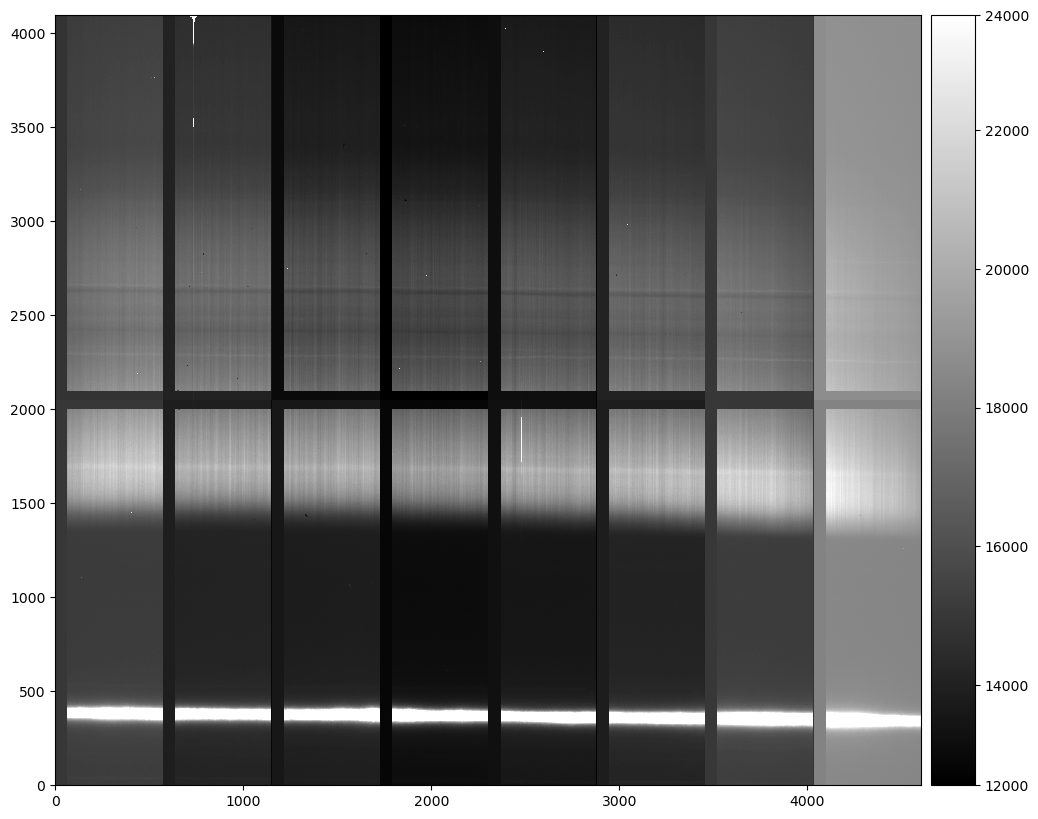

In [36]:
fig = plt.figure(figsize=(12,10))
afw_display = afwDisplay.Display(frame=fig)
afw_display.scale('linear', 'zscale',None)
#the_title = f"{index}, pseudo-postISR exp = {exp_selected_}, target = {object_}, airmass = {am_:.2f}, phys. filter = {filter_}-{grating_}"
afw_display.mtv(raw_img.image)

In [39]:
for exp_ in exposures_selected:
    raw_img_ = butler.get('raw', dataId={'exposure': exp_, 'instrument': 'LATISS', 'detector': 0}, collections = calibCollections)
    
    time_ = raw_img_.getMetadata().toDict()['EXPTIME']
    print(exp_,time_)

2022091200073 5.0
2022091400100 5.0
2022091400104 15.0
2022091400105 15.0
2022091400103 15.0
2022091400108 15.0
2022091400109 15.0
2022091400114 15.0
2022091400112 15.0
2022091400101 15.0
2022091400111 15.0
2022091400106 15.0
2022091400107 15.0
2022091400102 15.0
2022091400113 15.0
2022091400115 15.0
2022091400110 15.0
2022092200029 20.0
2022092200028 12.0
2022092200030 16.0
2022092200027 6.0
2022092200072 1.0
2022092200074 1.3
2022092200081 3.2
2022092200083 4.3
2022092200076 1.8
2022092200080 3.2
2022092200084 5.8
2022092200090 14.0
2022092200031 18.0
2022092200077 1.8
2022092200075 1.3
2022092200079 2.4
2022092200073 1.0
2022092200078 2.4
2022092200082 4.3
2022092200087 7.8
2022092200089 10.5
2022092200088 10.5
2022092200086 7.8
2022092200093 0.1
2022092200094 0.4
2022092200096 0.9
2022092200100 0.5
2022092200101 0.5
2022092200102 0.8
2022092200092 0.1
2022092200091 14.0
2022092200095 0.4
2022092200097 0.9
2022092200099 0.3
2022092200103 0.8
2022092200098 0.3
2022092300263 0.1
20220

KeyboardInterrupt: 

# Retrieve exposures from Butler and make pseudo-postISRCCD 

In [25]:
outdir_base = "./pseudo_postisrccd_img"
if not os.path.exists(outdir_base):
    os.makedirs(outdir_base)
    
outdir_list = []
if exp_date!='all':
    outdir_list.append(exp_date)
else:
    outdir_list.append('all_dates')
if source!='all':
    outdir_list.append(source)
else:
    outdir_list.append('all_sources')
if physical_filter!='all':
    outdir_list.append(physical_filter)
else:
    outdir_list.append('all_phys_filters')

outdir_label = str(outdir_list[0])
for elem_ in outdir_list[1:]:
    outdir_label = outdir_label+'_{0}'.format(elem_.replace('~','-'))

outdir = os.path.join(outdir_base,str(exp_date))
outdir = os.path.join(outdir_base,outdir_label)
if not os.path.exists(outdir):
    os.makedirs(outdir)

## Prepare ISR task and define its inputs with Butler 

In [37]:
# configuration
isr_config =  IsrTaskConfig()

In [38]:
isr_config.doDark = False
isr_config.doFlat =  False
isr_config.doFringe = False
isr_config.doDefect = True
isr_config.doLinearize = False
isr_config.doCrosstalk =  False
isr_config.doSaturationInterpolation = False
isr_config.overscan.fitType: 'MEDIAN_PER_ROW'
isr_config.doBias: True


In [39]:
isr_task = IsrTask(config=isr_config)

Prepare information and collections for calibration 

In [40]:
butler = dafButler.Butler(repo, collections=calibCollections)
camera = butler.get('camera', instrument=cameraName)
#bias = butler.get('bias',instrument=cameraName,detector=0)
#defects = butler.get('defects',instrument=cameraName,detector=0)


In [41]:
show_plot = True

Astropy scale transformations

In [42]:
transform = AsinhStretch() + PercentileInterval(99.)
#transform = PercentileInterval(98.)

In [43]:
exp_selected_ = exposures_selected[0]

raw_img= butler.get('raw', dataId={'exposure': exp_selected_, 'instrument': 'LATISS', 'detector': 0}, collections = collection)
bias = butler.get("bias",instrument=cameraName, exposure= exp_selected_, detector=0, collections=calibCollections)
defects = butler.get('defects',instrument=cameraName, exposure= exp_selected_,detector=0,collections=calibCollections)

meta = raw_img.getMetadata()
md = meta.toDict()

object_ = md['OBJECT']
am_ = md['AMSTART']
filter_ = md['FILTER']
grating_ = md['GRATING']

#fast ISR 
isr_img = isr_task.run(raw_img,bias=bias,defects=defects)

if show_plot:
    %matplotlib inline
    
    rotated_array = isr_img.exposure.image.array[::-1,::-1] #rotate the array 180 degrees
    #np.flip(np.flip(a, 1), 0)


    fig = plt.figure(figsize=(12,10))
    afw_display = afwDisplay.Display(frame=fig)
    afw_display.scale('linear', 'zscale',None)
    the_title = f"{index}, pseudo-postISR exp = {exp_selected_}, target = {object_}, airmass = {am_:.2f}, phys. filter = {filter_}-{grating_}"
    afw_display.mtv(isr_img.exposure.image,title=the_title)

NameError: name 'collection' is not defined

# Save in files

In [35]:
max_files = 10

In [36]:
for exp_selected_ in exposures_selected[:max_files]:
    
    #exposure_selected =row["date"]*100000+row["seq"]
    
    print(f"exposure selected = {exp_selected_}")


    raw_img= butler.get('raw', dataId={'exposure': exp_selected_, 'instrument': 'LATISS', 'detector': 0}, collections = collection)
    bias = butler.get("bias",instrument=cameraName, exposure= exp_selected_, detector=0, collections=calibCollections)
    defects = butler.get('defects',instrument=cameraName, exposure= exp_selected_,detector=0,collections=calibCollections)
    
    
    isr_img = isr_task.run(raw_img,bias=bias,defects=defects)
    
    arr=isr_img.exposure.image.array
    # 180 degree rotation
    rotated_array = arr[::-1,::-1] #rotate the array 180 degrees
    
    
    meta = raw_img.getMetadata()
    md = meta.toDict()

    #object_ = md['OBJECT']
    #am_ = md['AMSTART']
    #filter_ = md['FILTER']

    filename_out = f"exposure_{exp_selected_}_{physical_filter.replace('~','-')}_pseudo-postisrccd.fits"
    fullfilename_out=os.path.join(outdir,filename_out)
    
    print(f">>>>  output filename {filename_out}")
    
    hdr = fits.Header()
    
    for key,value in md.items():
        hdr[str(key)]=value
        
    if hdr['OBJECT']=='MU-COL':
        hdr['OBJECT'] = 'HD38666'
    # need this    
    hdr["AMEND"] = hdr["AMSTART"]
    try: 
        airmass_ = hdr["AIRMASS"]
    except:
        airmass_ = (hdr["AMEND"] + hdr["AMSTART"])/2.
        hdr["AIRMASS"] = airmass_
    
    # be aware weather data may be missing
    if hdr["AIRTEMP"] == None:
        hdr["AIRTEMP"] = 10.0

    if hdr["PRESSURE"] == None:
        hdr["PRESSURE"] = 744.

    if hdr["HUMIDITY"] == None:
        hdr["HUMIDITY"] = 50.

    if hdr["WINDSPD"] == None:
        hdr["WINDSPD"] = 5.

    if hdr["WINDDIR"] == None:
        hdr["WINDDIR"] = 0.   

    if hdr["SEEING"] == None:
        hdr["SEEING"] = 1.15
    
        
   
    
    # Be carefull for Spectractor, 2 hdu units are necessary
    
    primary_hdu = fits.PrimaryHDU(header=hdr)
    image_hdu = fits.ImageHDU(rotated_array)
    #image_hdu = fits.ImageHDU(arr)
    
    hdu_list = fits.HDUList([primary_hdu, image_hdu])
    
    hdu_list.writeto(fullfilename_out,overwrite=True)
    
    
    
    #if exposure_selected not in exposures_sel:
    #    break
    
    #if index>=0:
    #    break
    


exposure selected = 2022091400761


>>>>  output filename exposure_2022091400761_empty-holo4_003_pseudo-postisrccd.fits
exposure selected = 2022091400762


>>>>  output filename exposure_2022091400762_empty-holo4_003_pseudo-postisrccd.fits
exposure selected = 2022091400782


>>>>  output filename exposure_2022091400782_empty-holo4_003_pseudo-postisrccd.fits
exposure selected = 2022091400796


>>>>  output filename exposure_2022091400796_empty-holo4_003_pseudo-postisrccd.fits
exposure selected = 2022091400817


>>>>  output filename exposure_2022091400817_empty-holo4_003_pseudo-postisrccd.fits
exposure selected = 2022091400839


>>>>  output filename exposure_2022091400839_empty-holo4_003_pseudo-postisrccd.fits
exposure selected = 2022091400783


>>>>  output filename exposure_2022091400783_empty-holo4_003_pseudo-postisrccd.fits
exposure selected = 2022091400797


>>>>  output filename exposure_2022091400797_empty-holo4_003_pseudo-postisrccd.fits
exposure selected = 2022091400818


>>>>  output filename exposure_2022091400818_empty-holo4_003_pseudo-postisrccd.fits
exposure selected = 2022091400838


>>>>  output filename exposure_2022091400838_empty-holo4_003_pseudo-postisrccd.fits


## Check that the images were correctly saved 

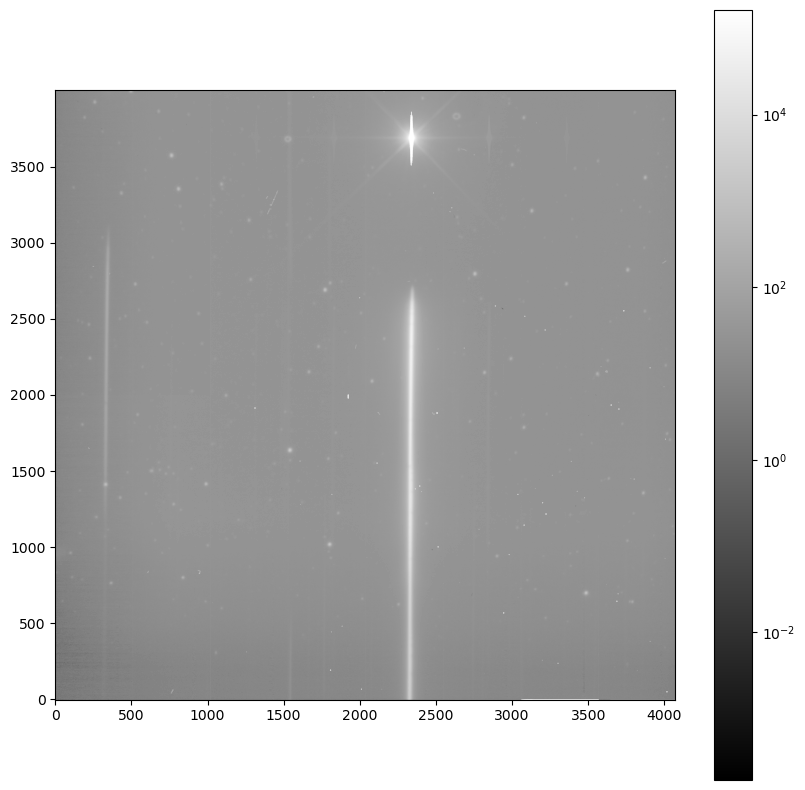

In [37]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
im = ax.imshow(rotated_array,cmap="gray",origin='lower',norm=LogNorm())
plt.colorbar(im,ax=ax)

## Now we look for the flats taken on the closest date to that of the selected exposure 

In [38]:
#calibCollections = ['LATISS/defaults','LATISS/raw/all']
#for col in registry.queryCollections("*LATISS/calib*"):
#    print(col)
#    calibCollections.append(col)
#calibCollections = ...

In [39]:
where_flats = "instrument='LATISS' AND physical_filter='empty~empty' AND exposure.observation_type='flat'"

In [40]:
flats_records = list(registry.queryDimensionRecords('exposure',where=where_flats))

In [51]:
#flats_records

In [42]:
print(len(flats_records))
assert len(flats_records)!=0

666


In [43]:
flats_records[0].id

2022091200073

In [44]:
flat_year = '2023'

In [45]:
flat_dates = []
for flat_ in flats_records:
    if flat_year in str(flat_.day_obs):
        flat_dates.append(flat_.day_obs)


In [46]:
flat_dates = np.unique(flat_dates)
print(flat_dates)

[20230112 20230116 20230118 20230214 20230321 20230327 20230404 20230420
 20230425 20230509 20230510 20230523 20230524 20230525 20230705 20230706
 20230724 20230725 20230726 20230727 20230801 20230802 20230803 20230811
 20230816 20230817 20230823 20230829 20230830]


In [47]:
flat_date = 20230116

In [48]:
flats_selected = []
for flat_ in flats_records:
    if flat_.day_obs==flat_date:
        flats_selected.append(flat_.id)
print(flats_selected)

[2023011600015, 2023011600014, 2023011600016]


Check that we can load the flats 

In [49]:
flat_arrays = []
for fid_ in flats_selected:
    flat_img = butler.get(
        "flat",
        instrument="LATISS", exposure=fid_, detector=0,
        collections=calibCollections)
    flat_arrays.append(flat_img.getImage().array)